# QSVM aplicado a um problema de classificação com padrão altamente complexo

Elaborado por:
- Equipe Qast - Beer Quantum Challenge (Ambev+QB) 2021

Neste notebook:

- Observamos a alta performance do Kernel quântico em problemas de classificação com padrões extremamente complexos, i.e. em casos onde a atribuição de classes {1, -1} aparenta ser praticamente aleatória.

- Mostramos também a incapacidade dos kernels clássicos mais comuns (implementados na biblioteca scikit-learn) em classificar tais dados. 

### 0. Importar bibliotecas

In [1]:
#general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#qiskit imports
from qiskit import Aer, BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.algorithms import QSVM, SklearnSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name



/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


### 2. Gerar dataset

/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')
/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/ml/datasets/ad_hoc.py:79: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  basis = aqua_globals.random.random((2 ** n, 2 ** n)) + \


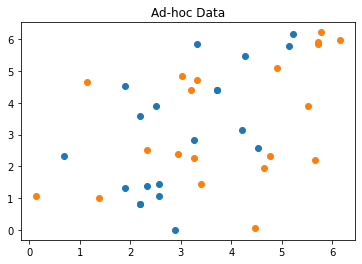

In [2]:
#Dataset sintético fornecido pelo Qiskit
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2

#200 instâncias de treino, 100 de teste
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10,
    n=feature_dim,
    gap=0.2,
    plot_data=True
)
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)

A fronteira de decisão necessária em $\mathbb{R}^2$ para realizar esta classifação é extremamente complexa

Os dados são organizados em:

- Dados de treino (20)
- Dados de teste (10)
- Dados extras, para previsão (20)

### 3. Implementar Kernel quântico

In [3]:
shots = 10e03
feature_dim = 2
seed = 1234

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

#executar e resultados
result = qsvm.run(quantum_instance)




/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/aqua/algorithms/classifiers/qsvm/qsvm.py:102: DeprecationWarning: The package qiskit.aqua.algorithms.classifiers is deprecated. It was moved/refactored to qiskit_machine_learning.algorithms.classifiers (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.classifiers',
/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


Visualização das fronteiras de decisão com dados de teste e predição

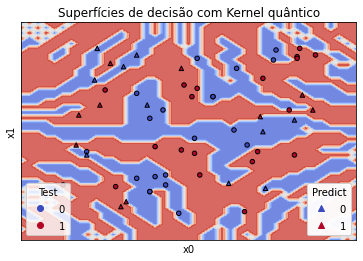

In [6]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


fig, ax = plt.subplots()
title = ('Superfícies de decisão com Kernel quântico')



X = np.concatenate([training_input['A'], training_input['B']], axis = 0) 
X0, X1 = X[:, 0], X[:, 1]
y = np.array([[0]*len(training_input['A']) + [1]*len(training_input['B'])]).ravel()
xx, yy = make_meshgrid(X0, X1, h = 0.2)
plot_contours(ax, qsvm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
scatter1 = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

X = datapoints[0] 
X0, X1 = X[:, 0], X[:, 1]
y = datapoints[1]
scatter2 = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', marker="^")

ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())

legend1 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Test")
ax.add_artist(legend1)


legend2 = ax.legend(*scatter2.legend_elements(),
                    loc="lower right", title="Predict")
ax.add_artist(legend2)

ax.set_title(title)
plt.show()

#Pode levar vário minutos para executar

Sucesso nas instâncias de teste: 100.0%

instâncias de predição:
  correto: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  predição:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  sucesso nas instâncias de predição: 100.0%


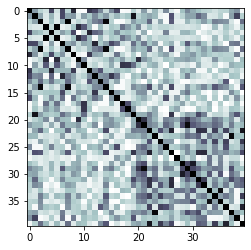

In [7]:
print(f'Sucesso nas instâncias de teste: {100*result["testing_accuracy"]}%')
print()
print('instâncias de predição:')
print(f'  correto: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  predição:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  sucesso nas instâncias de predição: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r');

$\textbf{Conclusão:}$ O Kernel quântico é capaz de criar fronteiras de decisão extremamente complexas, conseguindo acurácia de 100% (ou muito próximo disso) em treino e teste. Note que o segundo e quarto quadrante do Kernel são mais "escuros" que os outros dois. Isto porque, com o feature map utilizado, conseguimos colocar as instâncias da mesma classe mais próximas entre si, e distantes das da classe oposta, no espaço de Hilbert associado. Isto é, com o Kernel quântico, mesmos padrões complexos como este podem se tornar linearmente separáveis.

### 3. Implementar Kernel clássico (rbf)

In [8]:
csvm = SklearnSVM(training_input, test_input, datapoints[0])
result_classical = csvm.run()

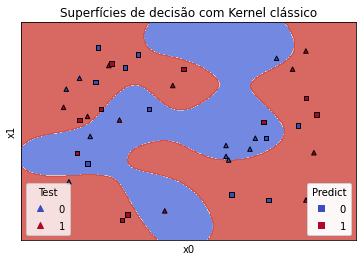

In [9]:

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


fig, ax = plt.subplots()
title = ('Superfícies de decisão com Kernel clássico')

X = np.concatenate([training_input['A'], training_input['B']], axis = 0) 


X = np.concatenate([test_input['A'], test_input['B']], axis = 0) 
X0, X1 = X[:, 0], X[:, 1]
y = np.array([[0]*len(test_input['A']) + [1]*len(test_input['B'])]).ravel()
xx, yy = make_meshgrid(X0, X1, h = 0.02)
plot_contours(ax, csvm, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
scatter2 = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', marker = '^')


X = datapoints[0] 
X0, X1 = X[:, 0], X[:, 1]
y = datapoints[1]
scatter3 = ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', marker = 's')

ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())




legend2 = ax.legend(*scatter2.legend_elements(),
                    loc="lower left", title="Test")
ax.add_artist(legend2)

legend3 = ax.legend(*scatter3.legend_elements(),
                    loc="lower right", title="Predict")
ax.add_artist(legend3)

ax.set_ylabel('x1')
ax.set_xlabel('x0')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

#Pode levar minutos para executar

Sucesso nas instâncias de teste: 75.0%

instâncias de predição:
  correto: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  predição:   ['B', 'B', 'B', 'B', 'B', 'B', 'A', 'A', 'A', 'B', 'B', 'A', 'B', 'B', 'B', 'A', 'B', 'B', 'B', 'B']
  sucesso nas instâncias de predição: 0.0%


<ipython-input-10-96108fd7c670>:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f'  sucesso nas instâncias de predição: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')


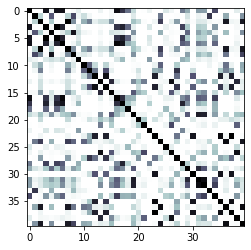

In [10]:
from qiskit.aqua.algorithms import SklearnSVM

print(f'Sucesso nas instâncias de teste: {100*result_classical["testing_accuracy"]}%')
print()
print('instâncias de predição:')
print(f'  correto: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  predição:   {result_classical["predicted_classes"]}')
predicted_labels = result_classical["predicted_labels"]
print(f'  sucesso nas instâncias de predição: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

kernel_matrix = result_classical['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');


$\textbf{Conclusão:}$ O Kernel clássico rbf (um dos mais comuns) acerta somente uma pequena quantidade dos dados de teste e de predição, podendo eventualmente ser ainda pior do que o método "naïve" de jogar uma moeda para atribuir uma classe para cada instância. Em um caso extremo como o da última execução, o kernel clássico não conseguiu classificar corretamente NENHUMA instância de previsão. Ou seja, o kernel clássico não consegue aprender o padrão complexo do database. Note que o padrão mencionado anteriormente, entre os quadrantes da matriz de Kernel, já não é mais perceptível, i.e. os dados já não são mais linearmente separáveis.